In [1]:
!pip install blosc2
!pip install hdbscan
!pip install bertopic

In [21]:
import pandas as pd
import numpy as np
import json
import requests
import es_core_news_lg

import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from kmodes.kprototypes import KPrototypes
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from umap import UMAP
from transformers.pipelines import pipeline

from bertopic import BERTopic
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from sklearn.cluster import KMeans

plt.style.use('ggplot')

In [22]:
path="pqr_processed.csv"
df=pd.read_csv(path, sep=';', index_col=0)
df.head()

,MOTIVO,PQR,USUARIO
0,Afiliaciones,mil veintitres senores en lozano identificad...,41859039
1,Faltante de medicamentos y aliadas,requiere medicamentos alginato sodio bicarbo...,52294841
2,Faltante de medicamentos y aliadas,gonzalez gonzalez de tardes cordial...,65090345
3,Citas Medicas,la inquietud queja prestada nombrado odontolo...,1053988549
4,Calidad Tecnico Cientifica,queja me dirijo presentar queja formal ciruja...,1047595573


In [23]:
df['PQR'] = df['PQR'].astype(str)
pqr = df['PQR'].tolist()

In [24]:
#stopwords
nlp = es_core_news_lg.load()
spanish_stop_words_spacy = nlp.Defaults.stop_words
vectorizer = CountVectorizer(lowercase = True, stop_words = list(spanish_stop_words_spacy))


In [25]:
#umap model
umap_model = UMAP(angular_rp_forest=True,
            low_memory=False,
            metric='cosine',
            min_dist=0.0,
            n_components=5,
            random_state=42,
            tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [39]:
#HBDSCAN_MODEL
""" cluster_model = HDBSCAN(
  min_cluster_size=100,
  metric='euclidean', 
  cluster_selection_method='eom',
  prediction_data=True, min_samples=5
) """

#kmeans
random_state = 2297
cluster_model = KMeans(
  n_clusters=80,
  random_state=random_state)

In [40]:

vectorizer_model = vectorizer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
#representation_model = KeyBERTInspired()
#representation_model = MaximalMarginalRelevance(diversity=0.8)


topic_model = BERTopic(
    hdbscan_model=cluster_model,
    umap_model=umap_model,
    ctfidf_model=ctfidf_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True)

topics, probs = topic_model.fit_transform(pqr)

#topic_model = BERTopic(embedding_model="PlanTL-GOB-ES/roberta-base-bne", calculate_probabilities=True, verbose=True)
#topics, probs = topic_model.fit_transform(pqr)

Batches: 100%|██████████| 177/177 [03:18<00:00,  1.12s/it]
2023-11-12 22:45:56,088 - BERTopic - Transformed documents to Embeddings
2023-11-12 22:46:06,848 - BERTopic - Reduced dimensionality
2023-11-12 22:46:09,564 - BERTopic - Clustered reduced embeddings


In [41]:
topic_model.visualize_topics()

In [42]:
# we observe the first 25 topics
top_topics = 25

topics_pivot = topic_model.get_topic_info()

events_count = topics_pivot['Count'].sum()

def calc_perc(row):
  return round(row['Count']*100/events_count, 2)

topics_pivot['Perc'] = topics_pivot.apply (lambda row: calc_perc(row), axis=1)

topics_pivot.head(top_topics)

,Topic,Count,Name,Representation,Representative_Docs,Perc
0,0,165,0_medicamento_medicamentos_agotado_dispensacion,"[medicamento, medicamentos, agotado, dispensac...",[estimado dirijo presentar relacion recibi e...,2.93
1,1,148,1_cuentas_copago_drogueria_pagina,"[cuentas, copago, drogueria, pagina, boleta, t...",[ senoreseps en superintendencia nacional de ...,2.63
2,2,137,2_tumor_cancer_piel_maligno,"[tumor, cancer, piel, maligno, benigno, metast...",[buen linea indica consternada recibe centr...,2.43
3,3,136,3_ojo_vision_oftalmologia_glaucoma,"[ojo, vision, oftalmologia, glaucoma, retina, ...",[ se senora radicando consagra disposicio...,2.41
4,4,133,4_rodilla_ortopedia_ortopedista_traumatologia,"[rodilla, ortopedia, ortopedista, traumatologi...",[ ardila circunvalar a circunvalar a circunval...,2.36
5,5,118,5_endocrinologia_tarros_agendar_botero,"[endocrinologia, tarros, agendar, botero, llam...",[respetados dada agende infarto hipertension ...,2.09
6,6,118,6_mancilla_stiven_veintitres_mil,"[mancilla, stiven, veintitres, mil, copia, apl...",[ cliente constitucion concordancia ley apar...,2.09
7,7,117,7_corazon_cardiologia_cardiologo_cardiaca,"[corazon, cardiologia, cardiologo, cardiaca, c...",[mediante presente pongo conocimiento queja p...,2.08
8,8,115,8_devolucion_pagos_planilla_aportes,"[devolucion, pagos, planilla, aportes, valor, ...",[les mes diciembre realice aporte mes corres...,2.04
9,9,106,9_transporte_ciudad_hospedaje_dialisis,"[transporte, ciudad, hospedaje, dialisis, tran...",[carrillo e rodriguez a a a de comed...,1.88


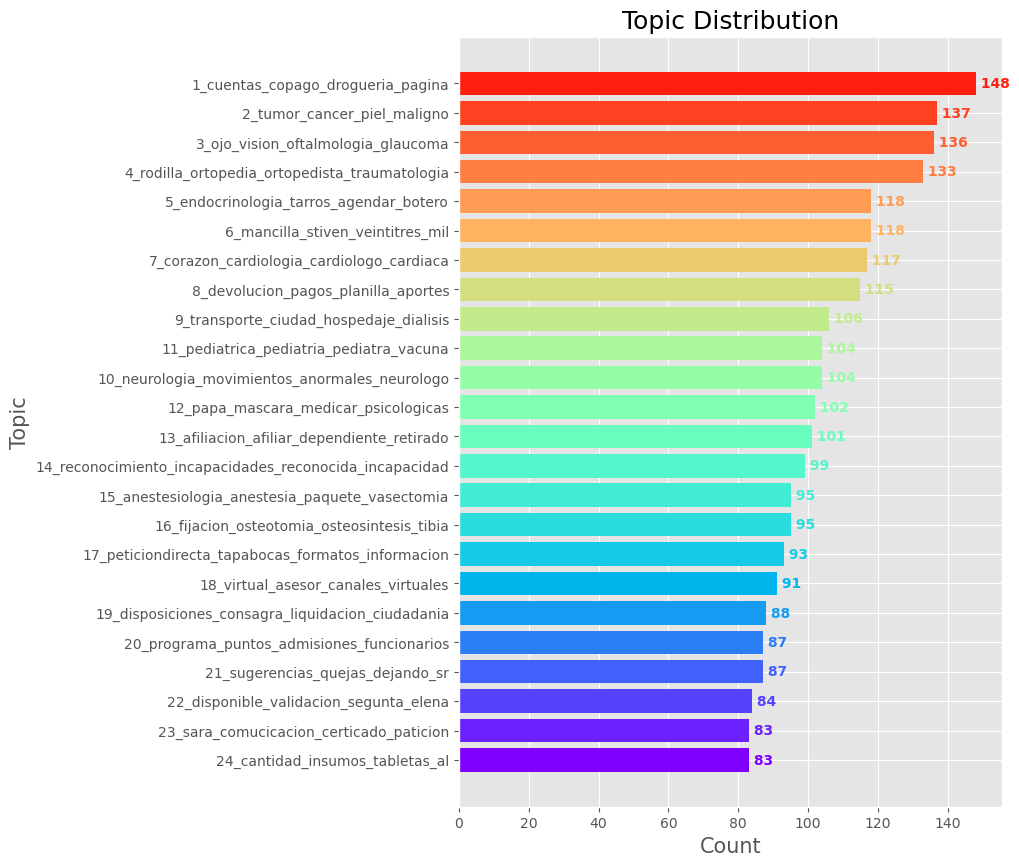

In [43]:
colors = plt.cm.rainbow(np.linspace(0, 1, top_topics))
iter_color = iter(colors)

fig = plt.figure(figsize=(7,10))

plt.barh('Name', 'Count',
         data=topics_pivot.head(top_topics).drop([0]).sort_values('Count',ascending=True), color=colors)
plt.xlabel("Count", size=15)
plt.ylabel("Topic", size=15)
plt.title("Topic Distribution", size=18)

for i, v in enumerate(topics_pivot.head(top_topics).drop([0])["Count"].sort_values(ascending=True)):
  c = next(iter_color)
  plt.text(v, i, " "+str(v), color=c, va='center', fontweight='bold')

In [44]:
#df processecd
export_df=topic_model.get_document_info(pqr,df=df)
file_name = "pqr_topic_result.csv"
export_df.to_csv(file_name, sep=';',encoding='utf-8')
export_df

,MOTIVO,PQR,USUARIO,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,Afiliaciones,mil veintitres senores en lozano identificad...,41859039,mil veintitres senores en lozano identificad...,6,6_mancilla_stiven_veintitres_mil,"[mancilla, stiven, veintitres, mil, copia, apl...",[ cliente constitucion concordancia ley apar...,mancilla - stiven - veintitres - mil - copia -...,False
1,Faltante de medicamentos y aliadas,requiere medicamentos alginato sodio bicarbo...,52294841,requiere medicamentos alginato sodio bicarbo...,24,24_cantidad_insumos_tabletas_al,"[cantidad, insumos, tabletas, al, validar, tab...",[chivara cl piso uribe javier chivara cl piso...,cantidad - insumos - tabletas - al - validar -...,False
2,Faltante de medicamentos y aliadas,gonzalez gonzalez de tardes cordial...,65090345,gonzalez gonzalez de tardes cordial...,67,67_droga_medicamento_reclamar_amorolfina,"[droga, medicamento, reclamar, amorolfina, mar...",[respetuosamente permito informarles aceptar ...,droga - medicamento - reclamar - amorolfina - ...,False
3,Citas Medicas,la inquietud queja prestada nombrado odontolo...,1053988549,la inquietud queja prestada nombrado odontolo...,53,53_dientes_dentales_carilla_dental,"[dientes, dentales, carilla, dental, exodoncia...",[luis romero e romero desde de diagnostico...,dientes - dentales - carilla - dental - exodon...,False
4,Calidad Tecnico Cientifica,queja me dirijo presentar queja formal ciruja...,1047595573,queja me dirijo presentar queja formal ciruja...,15,15_anestesiologia_anestesia_paquete_vasectomia,"[anestesiologia, anestesia, paquete, vasectomi...",[ juan pablo ortiz granda craa craa pablo orti...,anestesiologia - anestesia - paquete - vasecto...,True
...,...,...,...,...,...,...,...,...,...,...
5628,Medicina Laboral,buen solicito amable colaboracion realizando v...,901287668,buen solicito amable colaboracion realizando v...,14,14_reconocimiento_incapacidades_reconocida_inc...,"[reconocimiento, incapacidades, reconocida, in...",[buen senores comunicacion pqrs no de atenta ...,reconocimiento - incapacidades - reconocida - ...,False
5629,Cobertura,presencia organizacion gubernamental trabaja p...,891184665,presencia organizacion gubernamental trabaja p...,37,37_docente_administracion_ordenes_copagos,"[docente, administracion, ordenes, copagos, en...",[ proteccion social senores en consagrado ...,docente - administracion - ordenes - copagos -...,False
5630,Procesos Administrativos,de forma respetuosa permito queja cajera atend...,32994845,de forma respetuosa permito queja cajera atend...,8,8_devolucion_pagos_planilla_aportes,"[devolucion, pagos, planilla, aportes, valor, ...",[les mes diciembre realice aporte mes corres...,devolucion - pagos - planilla - aportes - valo...,False
5631,Prestaciones Economicas,yo calidad representante legal solicito pres...,1020600791,yo calidad representante legal solicito pres...,8,8_devolucion_pagos_planilla_aportes,"[devolucion, pagos, planilla, aportes, valor, ...",[les mes diciembre realice aporte mes corres...,devolucion - pagos - planilla - aportes - valo...,False
